# Assignment 3

## Objective of this assignment
The objective of this exercise is to become familiar with fitting decision trees and
making ROC curves in Python.


## ** Important: ** When handing in your homework:
+ Hand in the notebook **(and nothing else)** named as follows: StudentName1_snumber_StudentName2_snumber.ipynb
+ Provide clear and complete answers to the questions below under a separate header (not hidden somewhere in your source code), and make sure to explain your answers / motivate your choices. Add Markdown cells where necessary.
+ Source code, output graphs, derivations, etc., should be included in the notebook.
+ Hand-in: upload to Brightspace.
+ Include name, student number, assignment (especially in filenames)!
+ When working in pairs only one of you should upload the assignment, and report the name of your partner in your filename.
+ Use the Brightspace discussion board or email the student assistants for questions on how to complete the exercises.
+ If you find mistakes/have suggestions/would like to complain about the assigment material itself, please email me [Lisa] at `l.tostrams@science.ru.nl`


## Advised Reading and Exercise Material
**The following reading material is recommended:**

Pang-Ning Tan, Michael Steinbach, and Vipin Kumar, Introduction to Data Mining, section 4.1-4.6, as well as the included article on ROC curves.


## 3.1 Decision trees

In this part of the exercise we will fit decision trees using the scikitlearn classifier
`sklearn.tree.DecisionTreeClassifier`. As a splitting criterion, the function uses
one of the following two impurity measures:

\begin{equation} \textrm{gdi}(t) = -\sum_{i=1}^C p(i|t)^2 \quad \text{       equivalent to Gini(t)} \end{equation}   

\begin{equation}
\textrm{deviance}(t) = -2\sum_{i=1}^C p(i|t) \log p(i|t) \quad \text{equivalent to Entropy(t)} 
\end{equation}

We will analyze the wine data we have used previously. The wine data set has the following attributes, all of which are continuous: 


| #             | Attribute     | Unit  |
| ------------- |:-------------| -----:|
|1 | Fixed acidity (tartaric) | g/dm$^3$ |
|2 | Volatile acidity (acetic) | g/dm$^3$ |
|3 | Citric acid | g/dm$^3$ |
|4 | Residual sugar | g/dm$^3$ |
|5 | Chlorides | g/dm$^3$ |
|6 | Free sulfur dioxide | mg/dm$^3$ |
|7 | Total sulfur dioxide | mg/dm$^3$ |
|8 | Density | g/cm$^3$ |
|9 | pH | pH |
|10 | Sulphates | g/dm$^3$ |
|11 | Alcohol | % vol. | 


#### 3.1.1
(0.5 pts) Load the wine data set `Data/wine.mat` using the `scipy.io` `loadmat` function. This contains the same data as used in the earlier assignment, but with outliers and the 12th attribute already removed. Create data matrix $X$, class vector $y$, and the lists $attributeNames$ and $classNames$ with the data provided in the `wine.mat` file. Print out the  $attributeNames$ and $classNames$ to make sure it's a list of strings.

   ** hints: **   
*The object in wine.mat is a dictionary. The attributes are stored in matrix $X$, the class in vector $y$. $y$ is shaped as an array containing single element arrays. To flatten $y$, you can use `y.ravel()`, which unravels matrices into a 1d array. Attribute names and class names are stored in the attributeNames and classNames objects, which contain arrays, of which the first element contains the names. To get the names from those arrays, you can use list comprehension or for-loops. For more on list comprehension, check https://www.digitalocean.com/community/tutorials/understanding-list-comprehensions-in-python-3. For example, if you have an larger array containing nested arrays of which you want the first element, you can try `new_array = [nested_array[0] for nested_array in larger_array]`.*



In [242]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import stats

data = sio.loadmat('Data/wine.mat')

In [659]:
X = data['X']
y = data['y']
y = y.ravel()

attributeNames = [data['attributeNames'][0][0][0] for data['attributeNames'][0][0] in data['attributeNames'][0]]

classNames = []
for index in range(len(data['classNames'])):
    classNames.append(data['classNames'][index][0][0])

print('attributeNames: ', attributeNames)
print('\nclassNames: ', classNames)

attributeNames:  ['Alcohol', 'Volatile acidity', 'Citric acid', 'Residual sugar', 'Chlorides', 'Free sulfur dioxide', 'Total sulfur dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol']

classNames:  ['Red', 'White']


#### 3.1.2
 (1.5 pts) Fit a decision tree to the wine data in order to estimate if the wine is red or white. Use the Gini (gdi) splitting criterion. Use `min_samples_split=100` for the stopping criterion. Explain what happens when you change the values of the parameter `min_samples_split`. After fitting the tree, visualize it with the tree_print function in `treeprint.py` in the Toolbox folder. 

** hints: **   
*The `treeprint.py` file contains some documentation on how to use it. Helpfull documentation for the DecisionTreeClassifier function can be found at * http://scikit-learn.org/stable/modules/tree.html#classification  



In [301]:
## I get an error when I want to import the Toolbox. Therefore I just copied the code from the python script.

import operator

def treeprint(clf, attributeNames, classNames):
    """
    Print the tree of a sklearn DecisionTreeClassifier

    Parameters
    ----------
    clf : sklearn.tree.DecisionTreeClassifier object - A tree that has already been fit.
    attributeNames: vector of names of the variables
    classNames: vector of class names, names for the leafs
    """
    tlevel = _tree_rprint('', clf, attributeNames, classNames)
    print('<',end='')
    for i in range(5*tlevel - 2):
        print('-',end='')
    print('>')
    print('Tree Depth: ',tlevel)


def _tree_rprint(kword, clf, features, labels, node_index=0, tlevel_index=0, parent = 0, left=True):
    # Note: The DecisionTreeClassifier uses the Tree structure defined in:
    # 		github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx
    #       it is an array based tree implementation.
    # indent the nodes according to their tree level
    # LT changes 2017: 
    #     draw tree from left to right
    #     added numbering
    #     added arrows
    # LT changes 2018:
    #     some cleaning
    #     
    #  TODO: 
    #        clean up ugly string formatting code
    #        the following should use the TREE_LEAF constant defined in _tree.pyx
    #        instead of -1, not quite sure how to get at it from the tree user level
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        print(kword[:-4], end=' ' if kword else '')
        # get the majority label
        count_list = clf.tree_.value[node_index, 0]
        max_index, max_value = max(enumerate(count_list), key=operator.itemgetter(1))
        max_label = labels[max_index]
        print(max_label)
        return tlevel_index
    
    else:
        # compute and print node label
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        # recurse down the children
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        #some formatting stuff
        string = kword[:-9]
        if(left_index<11):
            string = kword[:-8]   
        if(left and node_index is not 0):
            leftstr = string[:-1]
            leftstr = leftstr+' '
        else:
            leftstr = string
        tmp = leftstr
        for i in range(tlevel_index+1 - len(string)):
            leftstr = leftstr+' '
        #print left rule
        ltlevel_index = _tree_rprint(leftstr+'  |->{} then'.format(left_index), clf, features, labels, left_index, tlevel_index+1, parent=node_index)
        if(node_index is 0):
            print(' ', end='')
        print(tmp+'  |')
        print(kword, end=' ' if kword else '')
        #print current rule
        print('if {} =< {:4.2f}: go to {}, else go to {}'.format(feature, threshold, left_index, right_index))   
        #more formatting hell
        if(not left):
            rightstr = string[:-1]
            rightstr = rightstr+' '
        else:
            rightstr = string
        tmp = rightstr
        for i in range(tlevel_index+1 - len(string)):
            rightstr = rightstr+' '
        if(node_index is 0):
            print(' ', end='')
        print(tmp+'  |')
        #print right rule
        rtlevel_index = _tree_rprint(rightstr+'  |->{} else'.format(right_index), clf, features, labels, right_index, tlevel_index+1, parent=node_index, left=False)
        # return the maximum depth of either one of the children
        return max(ltlevel_index,rtlevel_index)
    


In [633]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

decision_tree = DecisionTreeClassifier(min_samples_split=100)
decision_tree = decision_tree.fit(X, y)

treeprint(decision_tree, attributeNames, classNames)
print('\nFigure 1: Decisiontree of the wine data by using the Gini splitting criterion')

         |->3  White
         |
      |->2 then if Sulphates =< 0.56: go to 3, else go to 4
      |  |
      |  |->4  White
      |
   |->1 then if Chlorides =< 0.05: go to 2, else go to 5
   |  |
   |  |  |->6  White
   |  |  |
   |  |->5 else if Sulphates =< 0.37: go to 6, else go to 7
   |     |
   |     |  |->8  White
   |     |  |
   |     |->7 else if Density =< 0.99: go to 8, else go to 9
   |        |
   |        |     |->11  White
   |        |     |
   |        |  |->10 then if Residual sugar =< 1.10: go to 11, else go to 12
   |        |  |  |
   |        |  |  |  |->13  Red
   |        |  |  |  |
   |        |  |  |->12 else if Density =< 0.99: go to 13, else go to 14
   |        |  |     |
   |        |  |     |  |->15  Red
   |        |  |     |  |
   |        |  |     |->14 else if Chlorides =< 0.05: go to 15, else go to 16
   |        |  |        |
   |        |  |        |  |->17  Red
   |        |  |        |  |
   |        |  |        |->16 else if Sulphates =< 0.45:

----
The value of min_samples_split is the minimum amount of samples needed before a split will be made. So when this is a small number, a split will be made very easily and so the decision tree can get a very high depth. When the minimum number is higher, the decision tree will have less splits.
The higher this number, the more accurate the split will be. However, it should be dependent of the number of data points. When there is just a small amount of data points available and the min_samples_split is pretty high, very few splits or no splits at all will be made, simply because there are not enough data points.

----

#### 3.1.3

(0.5 pts) Show that a wine with the following attribute values would be classified as white by the tree fitted in 3.1.2, by applying the `predict()` function from the DecisionTreeClassifier to this sample.  Have another look at the visualized tree. Which attributes are used to classify this wine? 

| #             | Attribute     | Value  |
| ------------- |:-------------| -----:|
|1 | Fixed acidity (tartaric) | 6.9 g/dm$^3$ |
|2 | Volatile acidity (acetic) | 1.09 g/dm$^3$ |
|3 | Citric acid | 0.06 g/dm$^3$ |
|4 | Residual sugar | 2.1 g/dm$^3$ |
|5 | Chlorides | 0.0061 g/dm$^3$ |
|6 | Free sulfur dioxide | 12 mg/dm$^3$ |
|7 | Total sulfur dioxide | 31 mg/dm$^3$ |
|8 | Density | 0.99 g/cm$^3$ |
|9 | pH | 3.5 |
|10 | Sulphates | 0.64 g/dm$^3$ |
|11 | Alcohol | 12 % vol. | 

** hints: **
*If you don't know how to classify input values with a tree, see the help documentation for the DecisionTreeClassifier function on how to predict the label for a sample. *

In [372]:
test = np.array([6.9, 1.09, 0.06, 2.1, 0.0061, 12, 31, 0.99, 3.5, 0.64, 12]).reshape(1, -1)

prediction = decision_tree.predict(test)
print('This should be a {} wine'.format(classNames[int(prediction)])) #prediction is stored as string

This should be a White wine


----
The following attributes are used:
- Total sulfur dioxide
- Chlorides
- Sulphates

----

#### 3.1.4
(1 pts) Classify all the wines in the wine data set. What percentage of the wine data is classified correctly by the tree?



In [662]:
predictions = decision_tree.predict(X)
print('{:12.2f} % is classified correctly.'.format(accuracy_score(y, predictions)*100))

       98.68 % is classified correctly.


----
It is printed above, 98.68% is classified correctly by the tree.

----

## 3.2 Decision tree pruning using cross-validation

In this exercise we will use cross-validation to prune a decision tree. When applying cross-validation the observed data is split into training and test sets, i.e., `X_train`, `y_train` and `X_test` and `y_test`. We train the model on the training data and evaluate the performance of the trained model on the test data.

#### 3.2.1
(2 pts) We are again using the wine data set `Data/wine.mat`. Divide the data into a training and a test data set (see hints!). Fit a decision tree to the training data using the Gini (`gdi`) splitting criterion.

Now, we want to find an optimally pruned decision tree by *modifying its maximum depth*. For different values of the parameter `depth` (from 2 to 20), 
+ first fit the decision tree
+ then compute the classification error on the training and test set (this is called holdout cross-validation)

When you've done this for `depth` values 2,...,20, plot the training and test classification error as a function of the tree depth in the same figure. This will show us what the optimal pruning depth is for the training set, but also how well this generalizes to a test set. 


** hints: **  
*Take a look at the module `sklearn.model_selection` and see how it can be used to partition the data into a training and a test set (holdout validation, `train_test_split()` function). Note that the package also contains functions to partition data for K-fold cross-validation. Some of the functions can ensure that both training and test sets have roughly the same class proportions. The error is 1-accuracy. The easiest way to compute the accuracy is by using the sklearn metrics module: 
 https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html *

What appears to be the optimal tree depth? Do you get the same result when you run your code again, generating a new random split between training and test data?


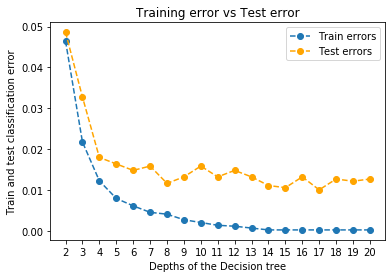

Figure 2: The error rate for training and testing as a function of the tree depth.


In [644]:
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

min_depth = 2
max_depth = 20

test_errors = []
train_errors = []

for depth in range(min_depth, max_depth+1):
    clf = DecisionTreeClassifier(max_depth = depth)
    clf = clf.fit(X_train, y_train)

    test_predictions = clf.predict(X_test)
    train_predictions = clf.predict(X_train)
    
    test_accuracy = accuracy_score(y_test, test_predictions)
    train_accuracy = accuracy_score(y_train, train_predictions)
    
    test_error = 1 - test_accuracy
    train_error = 1 - train_accuracy
    
    test_errors.append(test_error)
    train_errors.append(train_error)

plt.plot(range(2,max_depth+1), train_errors, '--o', label = 'Train errors')
plt.plot(range(2,max_depth+1), test_errors, '--o', color='orange', label = 'Test errors')
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.legend()
plt.title('Training error vs Test error')
plt.xlabel('Depths of the Decision tree')
plt.ylabel('Train and test classification error')
plt.show()
print('Figure 2: The error rate for training and testing as a function of the tree depth.')

----
The best depth of the tree is a depth of 8, since then the error of the test data is almost the lowest. With more depths, the errors will decrease with a very small amount but it will take a lot more computations. So for the effiency it's the best to choose 8 as depth.
We shouldn't look at the train errors, since that data is fitted/overfitted. So the higher the depth, the lower the errors.

The results are every time different when you run the code, unless you set a seed. We set a seed for the randomly splitting the data into a test and train set, but it appears you also have to set a seed for making the decision tree.
The seed will make sure that the data will be randomly shuffled in the same way when you run the code multiple times.

----

#### 3.2.2
(1.5 pts) Repeat the exercise above, using 10-fold cross-validation. K-fold cross-validation works by splitting X into K partitions of equal length. Then in each fold, you choose K-1 partitions as the training set and the remaining partition as the test set. Every partition gets a turn being a test set. For a very nice simple explanation of how (and why) K-fold works, check out http://www.dummies.com/programming/big-data/data-science/resorting-cross-validation-machine-learning/


For each fold, fit a decision tree on the training set and evaluate its performance on the test set. Finally, compute the average classification errors on the test- and training sets across the 10 cross-validation folds and plot them as a function of the tree depth.

** hints: **
*This time the `KFold()` function from the module `sklearn.model_selection` can be used to partition the data into the 10 training and test partitions. Check out http://scikit-learn.org/stable/modules/cross_validation.html#k-fold for an example of how to acces the indices for the training set and the test set in each fold. Those indices can then be used to create the training and test set, e.g. `X_train = X[train_indices]`*

*If you are creating a for loop iterating over an object where you both need the index and the elements of the object, you can enumerate the object. For example:*

`
for index, (element) in enumerate(object):
    array[index] = operation(element)
`
 

What appears to be the optimal tree depth? Do you get the same result when you run your code again, generating a new random split between training and test data? How about 100-fold cross-validation?


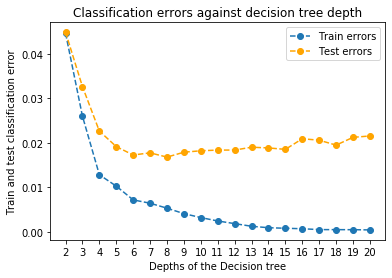

Figure 3: The error rate for training and testing as a function of the tree depth.


In [645]:
from sklearn.model_selection import KFold

min_depth = 2
max_depth = 20
n_splits = 100
kf = KFold(n_splits = n_splits)

test_errors = []
train_errors = []


for depth in range(min_depth, max_depth+1):
    temp_test_errors = []
    temp_train_errors = []
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test =  X[train_index], X[test_index], y[train_index], y[test_index]
    
        clf = DecisionTreeClassifier(max_depth = depth)
        clf = clf.fit(X_train, y_train)

        test_predictions = clf.predict(X_test)
        train_predictions = clf.predict(X_train)
    
        test_accuracy = accuracy_score(y_test, test_predictions)
        train_accuracy = accuracy_score(y_train, train_predictions)
    
        test_error = 1 - test_accuracy
        train_error = 1 - train_accuracy
    
        temp_test_errors.append(test_error)
        temp_train_errors.append(train_error)
        
    mean_test_errors = np.mean(temp_test_errors)
    temp_test_errors = np.mean(temp_train_errors)
    
    test_errors.append(mean_test_errors)
    train_errors.append(temp_test_errors)
    

plt.plot(range(2,21), train_errors, '--o', label = 'Train errors')
plt.plot(range(2,21), test_errors, '--o', color='orange', label = 'Test errors')
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.legend()
plt.title('Classification errors against decision tree depth')
plt.xlabel('Depths of the Decision tree')
plt.ylabel('Train and test classification error')
plt.show()
print('Figure 3: The error rate for training and testing as a function of the tree depth.')

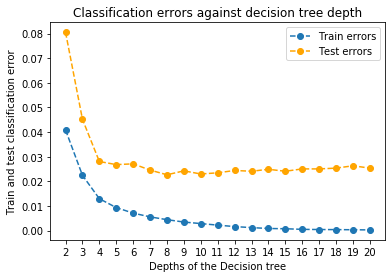

Figure 4: The error rate for training and testing as a function of the tree depth.


In [646]:
min_depth = 2
max_depth = 20
n_splits = 10
kf = KFold(n_splits = n_splits)

test_errors = []
train_errors = []


for depth in range(min_depth, max_depth+1):
    temp_test_errors = []
    temp_train_errors = []
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test =  X[train_index], X[test_index], y[train_index], y[test_index]
    
        clf = DecisionTreeClassifier(max_depth = depth)
        clf = clf.fit(X_train, y_train)

        test_predictions = clf.predict(X_test)
        train_predictions = clf.predict(X_train)
    
        test_accuracy = accuracy_score(y_test, test_predictions)
        train_accuracy = accuracy_score(y_train, train_predictions)
    
        test_error = 1 - test_accuracy
        train_error = 1 - train_accuracy
    
        temp_test_errors.append(test_error)
        temp_train_errors.append(train_error)
        
    mean_test_errors = np.mean(temp_test_errors)
    temp_test_errors = np.mean(temp_train_errors)
    
    test_errors.append(mean_test_errors)
    train_errors.append(temp_test_errors)
    

plt.plot(range(2,21), train_errors, '--o', label = 'Train errors')
plt.plot(range(2,21), test_errors, '--o', color='orange', label = 'Test errors')
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.legend()
plt.title('Classification errors against decision tree depth')
plt.xlabel('Depths of the Decision tree')
plt.ylabel('Train and test classification error')
plt.show()
print('Figure 4: The error rate for training and testing as a function of the tree depth.')

----
After every run, the errors are different, untill you set a seed. Just like with the previous exercise. 
When using 100-fold cross-validation, a lot more computations has to be done so the runtime is very long.

With using 100-fold cross-validation a depth of 6 is the best and then the test error has a rate of 0.018.
By using 10-fold cross-validation, the best depth is 8 and the test error has a rate of 0.022.

So the gain by using 100-fold cross-validation is very small compared to using 10-fold cross-validation while 10-fold cross-validation is a lot more efficient. So it's better to use 10-fold cross-validation.

When using 100-fold cross-validation the outcomes are more equally though after each run. Which isn't strange, since there are a lot more samples and they are smaller too. So they will differ less from each other after each run.

----

 ## 3.3 ROC curves, AUC scores, and the sign test

In this exercise we will use ROC curves and the sign test to compare classifiers. Study the lecture slides and the paper 'ROC Graphs: Notes and Practical Considerations for Researchers' by Tom Fawcett included with the homework assignment (ROC101.pdf). It describes all you need to know (and much, much more..) about ROC curves. The method explained for computing the area under the curve is unnecessarily complicated. A simpler formula is:
$$
    \mbox{AUC} = {1 \over m n} \sum_{i=1}^m \sum_{j=1}^n \mathbf{\large 1}_{p_i > p_j} \: .
   $$
Here $i$ runs over all $m$ data points with true label 1, and $j$ runs over all $n$ data points with true label $0$; $p_i$ and $p_j$ denote the probability score assigned by the classifier to data point $i$ and $j$, respectively. $\mathbf{\large 1}$ is the indicator function: it outputs $1$ if the condition (here $p_i > p_j$) is satisfied and $0$ otherwise. *Simply put: this formula computes how often the probability of a data point with true label 1 is higher than the probability of data points with true label 0. This is then divided by the total number of comparisons between probabilities.*
    

#### 3.3.1
(0.25 pts) To make sure you understand how ROC works, make an ROC curve and calculate the AUC (on paper) with the following data:

`
labels = [0,0,0,1,0,1,1,0,1,1]
classifier_probs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
`
    
What's the AUC you calculated? Do you think this classifier works well?


[[0.   0.   0.   1.   0.   1.   1.   0.   1.   1.  ]
 [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.99]
 [5.   5.   5.   4.   4.   3.   2.   2.   1.   0.  ]
 [4.   3.   2.   2.   1.   1.   1.   0.   0.   0.  ]
 [1.   2.   3.   3.   4.   4.   4.   5.   5.   5.  ]
 [0.   0.   0.   1.   1.   2.   3.   3.   4.   5.  ]
 [1.   1.   1.   0.8  0.8  0.6  0.4  0.4  0.2  0.  ]
 [0.8  0.6  0.4  0.4  0.2  0.2  0.2  0.   0.   0.  ]]


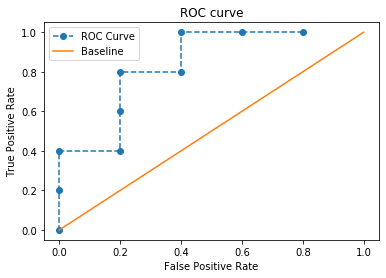

Figure 5: ROC Curve and baseline which stands for random guessing


In [654]:
## steps to take

labels = np.array([0,0,0,1,0,1,1,0,1,1])
classifier_probs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

## Add treshold row and use probabillity as threshold
ROC_table = np.vstack([labels, classifier_probs])

TP = []
## All with label 1 and prob above threshold
for i in range(len(labels)):
    filter = labels == 1
    TP.append(len(classifier_probs[filter][classifier_probs[filter] > classifier_probs[i]]))

## All with label 0 but prob above threshold
FP = []
for i in range(len(labels)):
    filter = labels == 0
    FP.append(len(classifier_probs[filter][classifier_probs[filter] > classifier_probs[i]]))
    
# All with label 0 and probabillity below threshold
TN = []
for i in range(len(labels)):
    filter = labels == 0
    TN.append(len(classifier_probs[filter][classifier_probs[filter] <= classifier_probs[i]]))
     
# All with label 1 but prob below threshold
FN = []
for i in range(len(labels)):
    filter = labels == 1
    FN.append(len(classifier_probs[filter][classifier_probs[filter] <= classifier_probs[i]]))
           

ROC_table = np.vstack([ROC_table, TP])
ROC_table = np.vstack([ROC_table, FP])
ROC_table = np.vstack([ROC_table, TN])
ROC_table = np.vstack([ROC_table, FN])

TPR = []
for i in range(len(labels)):
    TPR.append(ROC_table[2][i]/(ROC_table[2][i]+ ROC_table[5][i]))
ROC_table = np.vstack([ROC_table, TPR])

FPR = []
for i in range(len(labels)):
        FPR.append(ROC_table[3][i]/(ROC_table[3][i]+ ROC_table[4][i]))
ROC_table = np.vstack([ROC_table, FPR])

print(ROC_table)
import pandas as pd
df = pd.DataFrame(ROC_table)

plt.plot(df.iloc[7], df.iloc[6], '--o', label = 'ROC Curve')
plt.plot([0,1], [0,1], label = 'Baseline')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('Figure 5: ROC Curve and baseline which stands for random guessing')

----
This classifier works well because in the ideal situation the AUC is 1 and worst is 0. For this classifier the AUC value is 0.84. Because the AUC value is closer to 1 than 0.5, where the model doesn't have any classifying capacity, the classfier performs quite well.

Normally the ROC Curve goes to 1.0. We couldn't manage to plot it here in Python to 1.0.

----

#### 3.3.2
  Load the file `Data/classprobs.xls` using the Pandas `read_excel` function. Inspect the data and cast it to an array with the `.values` attribute. The first column gives the true class label (either 0 or 1). The second and third column give the probabilistic scores for two different classifiers. The higher this probability, the more certain the classifier is that the example belongs to class 1 (instead of class 0).


In [663]:
data_classprobs = pd.read_excel('Data/classprobs.xls')
data_classprobs = data_classprobs.values

#### 3.3.3
(1 pts) Calculate the ROC curves for both of the classifiers by calculating the FP and TP rates and plot them in the same plot. Make the plot yourself as opposed to using a library! Also plot a dashed line on the diagonal to represent random guessing in the same figure. Interpret the obtained results. Do both classifiers perform better than random guessing?

** hints: **  
*The function `sklearn.metrics.roc_curve` can be used for computing the FP and TP rates. You can then plot them using the `matplotlib.pyplot` `plot` function. Check the documentation on how to plot a dashed line. Remember to include a legend!* 

**An extra tip: the sign test example below includes a figure with dashed lines and a legend...**
 

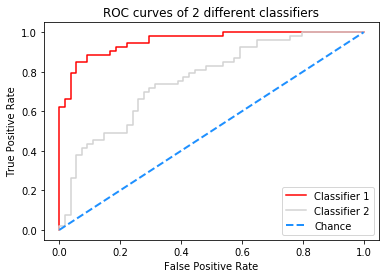

Figure 6: ROC of 2 different classifiers predicting an outcome of the same data


In [664]:
from sklearn import metrics

fpr1, tpr1, thresholds1 = metrics.roc_curve(data_classprobs[:,0], data_classprobs[:,1])
fpr2, tpr2, thresholds2 = metrics.roc_curve(data_classprobs[:,0], data_classprobs[:,2])

plt.plot(fpr1, tpr1, '-', label = 'Classifier 1', color = 'r')
plt.plot(fpr2, tpr2, '-', label = 'Classifier 2', color = 'lightgray')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='dodgerblue',
         label='Chance')
plt.title('ROC curves of 2 different classifiers')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('Figure 6: ROC of 2 different classifiers predicting an outcome of the same data')

----
Both classifiers perform better than the random guessing, since those curves are at the left side of the line of the random guessing. That means that the classifiers make better predictions.

----

#### 3.3.4
(0.5 pts) Compute the AUC scores (area under the curve) of both classifiers using the formula given above. **Write your own code for this calculation.** Do the AUC scores indicate that the classifiers are performing better than this baseline?




 

In [592]:
m = data_classprobs[data_classprobs[:,0]== 1]
n = data_classprobs[data_classprobs[:,0]== 0]

AUC1 = 0
AUC2 = 0
for index in range(len(m)):
    for index2 in range(len(n)):
        if (m[index,1] > n[index2,1]):
            AUC1 = AUC1 + 1
        if (m[index,2] > n[index2,2]):
            AUC2 = AUC2 + 1

AUC1 = (1/(len(m)*len(n))) * AUC1
AUC2 = (1/(len(m)*len(n))) * AUC2

print('The AUC of classifier 1 is: {0} \nThe AUC of classifier 2 is: {1}'.format(AUC1,AUC2))

The AUC of classifier 1 is: 0.9556254367575122 
The AUC of classifier 2 is: 0.7613556953179594


----
The AUC also shows that both classifiers are performing better. The area under the curves is greater than the area under the baseline. The AUC of the baseline is 0.5 x 1 x 1 = 0.5

----


#### 3.3.5
(0.25 pts) Using a threshold of 0.5, translate the probability scores to predicted class labels, and compute the accuracy for each of the classifiers.

** hint: **

*Take a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html *

In [665]:
data_classprobs[:,1] = data_classprobs[:,1] >= 0.5
data_classprobs[:,2] = data_classprobs[:,2] >= 0.5

accuracy1 = accuracy_score(data_classprobs[:,0], data_classprobs[:,1])
accuracy2 = accuracy_score(data_classprobs[:,0], data_classprobs[:,2])

print('The accuracy of classifier 1 with threshold 0.5 is: {0} \nThe accuracy of classifier 2 with threshold 0.5 is: {1}'.format(accuracy1,accuracy2))

The accuracy of classifier 1 with threshold 0.5 is: 0.8598130841121495 
The accuracy of classifier 2 with threshold 0.5 is: 0.6915887850467289


#### 3.3.6
(1 pts) Create the 2x2 table (or array, or list, or dataframe..) of wrong and correct classifications by the first and the second classifier, like in the lecture slides (lecture on model evaluation, part on the sign test). Perform a sign test to test whether the performance of the two classifiers is significantly different at a significance level of 0.05. **If you are not familiar with sign testing, you can read the example provided below.**


** hints: **  
*As explained in the lecture slides, the sign test is a binomial test on the lower-left ($N_{1<2}$) and upper-right ($N_{1>2}$) elements of the cross table. Unlike in the lecture slides, here you need to perform a two-sided test: $$\textrm{p-value} = P(W \leq \min(N_{1<2},N_{1>2}) \textrm{ or } W \geq  \max(N_{1<2},N_{1>2})$$
The function `scipy.stats.binom.cdf` can be used to compute the cumulative density of the binomial distribution.
For more information on the sign test, see the included paper by Salzberg (signtest.pdf, in particular section 3.1).*

In [667]:
from scipy.stats import binom

corrects = 0
wrongs = 0
m2_wrong = 0
m1_wrong = 0

for index in range(len(data_classprobs)):
    if (data_classprobs[index,0] == data_classprobs[index,1] == data_classprobs[index,2]):
        corrects = corrects + 1
    elif (data_classprobs[index,1] == data_classprobs[index,2] != data_classprobs[index,0]):
        wrongs = wrongs + 1
    elif (data_classprobs[index,1] != data_classprobs[index,2] and data_classprobs[index,1] == data_classprobs[index,0]):
        m2_wrong = m2_wrong + 1
    elif (data_classprobs[index,1] != data_classprobs[index,2] and data_classprobs[index,2] == data_classprobs[index,0]):
        m1_wrong = m1_wrong + 1
        
table = np.array([[corrects, m2_wrong], [m1_wrong,wrongs]])
print(table)

p_value1 = 1 - binom.cdf(max(m1_wrong,m2_wrong)-1, m1_wrong+m2_wrong, 0.5)
p_value2 = binom.cdf(min(m1_wrong,m2_wrong), m1_wrong+m2_wrong, 0.5)
p_value = p_value1 + p_value2
print('\nThe p-value is:', p_value)

[[66 26]
 [ 8  7]]

The p-value is: 0.0029350556433200854


----
The p-value is 0.0029 which is smaller than 0.05, so the performance of the two classifiers is significanlty different.

----

## Example two-sided sign test

Imagine you have a lucky coin, that you are certain does not result in heads 50% of the times you flip it. However, you friend (lets call him *zero_hypothesis*) claims that your coin is just like his random coin. To verify whether this is true, you decide to compare the performance (you are a scientist after all) of your lucky coin resulting in heads to the performance of his random coin resulting in heads with a sign test. How do you do this?

First, you collect data. Assume you place 23 bets. During those 23 bets, you both flip your respective coins. It was determined that if one of you flipped head while the other didn't, that person won the bet, and the other person lost. If you both got the same outcome, neither of you won. 1 stands for head, and 0 for tails. These were your results:

In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

#results
lucky_coin = np.array([1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,0,1])
random_coin= np.array([0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1,0,0,0,0,0,0])

print('----------lucky | random \n',*['bet {:<5}  | {} | {}\n'.format(t[0],t[1],t[2]) for t in zip(range(0,len(lucky_coin)),lucky_coin,random_coin)],'-----\n')

----------lucky | random 
 bet 0      | 1 | 0
 bet 1      | 1 | 1
 bet 2      | 1 | 0
 bet 3      | 0 | 1
 bet 4      | 1 | 0
 bet 5      | 1 | 1
 bet 6      | 1 | 0
 bet 7      | 1 | 0
 bet 8      | 1 | 0
 bet 9      | 0 | 1
 bet 10     | 1 | 0
 bet 11     | 1 | 1
 bet 12     | 1 | 0
 bet 13     | 1 | 1
 bet 14     | 0 | 1
 bet 15     | 1 | 1
 bet 16     | 1 | 1
 bet 17     | 0 | 0
 bet 18     | 1 | 0
 bet 19     | 1 | 0
 bet 20     | 1 | 0
 bet 21     | 0 | 0
 bet 22     | 1 | 0
 -----



Now you calculate how often in any pair of outcomes one coin *won*, i.e. one coin flipped to head while the other flipped to tails.

In [2]:
N_l = sum((lucky_coin == 1) & (random_coin == 0)) #how often your lucky coin won
N_r = sum((lucky_coin == 0) & (random_coin == 1)) #how often the random coin won
N = N_l + N_r #how often one coin was a winner
print('The lucky coin won {} times, while the random won {} times.'.format(N_l,N_r))

The lucky coin won 12 times, while the random won 3 times.


You observed 15 times that one coin won. If both coins resulted in heads 50% of the time, like *zero_hypothesis* stated, you'd expect that both coins have 50% chance of being the winner. So the probability distributions for both N_l and N_r should look something like this, assuming that *zero_hypothesis* is right:

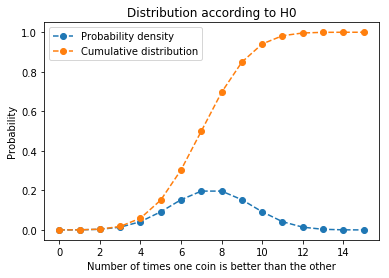

In [3]:
b = binom(N,0.5) #N=observations of inequality, p=prob of one coin being better, which is 0.5 according to your H0
plt.plot(b.pmf(range(N+1)), '--o',label = 'Probability density')
plt.plot(b.cdf(range(N+1)), '--o',label = 'Cumulative distribution')
plt.legend()
plt.xlabel('Number of times one coin is better than the other')
plt.ylabel('Probability')
plt.title('Distribution according to H0')
plt.show()

(Of course this is a discrete probability function, so you're not interested in values between integers.)

As you can see, according to *zero_hypothesis*, 7 and 8 are the most likely values for both N_l and N_r. But this is not what you observed in your data. To conclude that *H0* is false, you need to show that your outcome is unlikely under the assumption that *H0* is true: the values you observed are so extreme that these values or more extreme values occur less than 5% of the time (*p-value < 0.05*). So how unlikely is it that one coin is better 12 times or more, and the other is better 3 times or less?

It's the sum of the values of the probability density function (pdf or pmf in the python doc) at  0,1,2 and 3, plus the sum of the values of the pdf at 12,13,14 and 15. 

This is equal to the value of the cumulative distribution function (cdf) at 3, plus 1 minus the value of cdf at 11 (since `1-cdf(11)` represents the probability of observing 12 or bigger).

In [4]:
p_value = b.cdf(min(N_r,N_l)) + (1-b.cdf(max(N_r,N_l)-1))
print('The p-value is {:.3f}'.format(p_value))

The p-value is 0.035


So your observations are very unlikely if *zero_hypothesis* is right. By statistical theory, you can now say that you have significant reason to reject their opinion. Now the hardest part of statistics: convincing your non-scientist friends.